In [1]:
# Nominal interest rate from https://fred.stlouisfed.org/series/GS1
# Real interest rate from https://fred.stlouisfed.org/series/WFII10
#
# Download as CSV files
#

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_nominal = pd.read_csv("./data/GS1.csv")
df_real = pd.read_csv("./data/WFII10.csv")

def plot_rates(df, fontsize=16, savefig=True):
    if df is df_nominal:
        r_type = "nominal"
    elif df is df_real:
        r_type = "real"

    fig, ax = plt.subplots(figsize=(9, 5))

    ax.plot(df[:, 0], df[:, 1], label=f"{r_type} interest rate")

    ax.plot(df[:, 0], np.zeros(df[:, 1]), c="k", ls="--")

    ax.set_xlim(df[0, 0], df[:, 0])

    ax.legend(fontsize=fontsize, frameon=False)

    if savefig:
        fig.savefig(f"../figures/plot_interest_rates_{r_type}.pdf")

InvalidIndexError: (slice(None, None, None), 0)

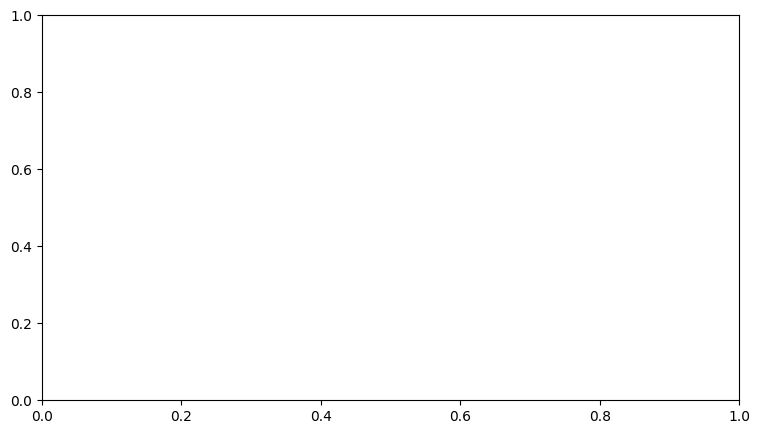

In [2]:
plot_rates(df_nominal, savefig=True)

InvalidIndexError: (slice(None, None, None), 0)

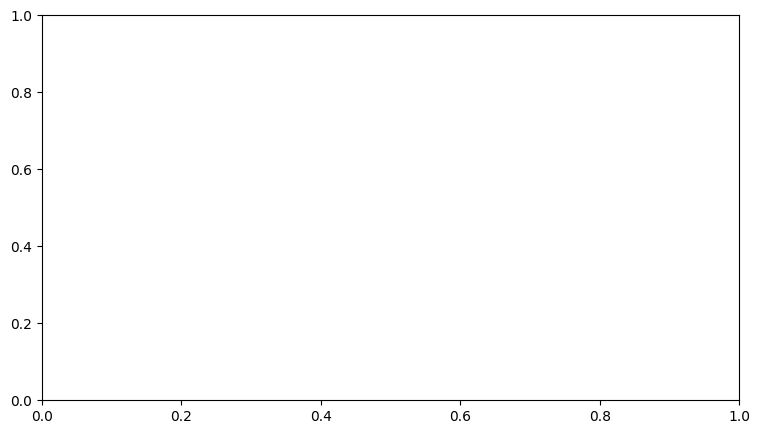

In [3]:
plot_rates(df_real, savefig=True)

In [4]:
"""
Price-dividend ratio in a model with dividend and consumption growth.

"""

from quantecon.markov import tauchen
import numpy as np
from collections import namedtuple


# NamedTuple Model
Model = namedtuple("Model", ("x_vals", "P", "β", "γ",
                            "μ_c", "σ_c", "μ_d", "σ_d"))


def create_asset_pricing_model(
        n=200,               # state grid size
        ρ=0.9, ν=0.2,        # state persistence and volatility
        β=0.99, γ=2.5,       # discount and preference parameter
        μ_c=0.01, σ_c=0.02,  # consumption growth mean and volatility
        μ_d=0.02, σ_d=0.1):  # dividend growth mean and volatility
    """
    Creates an instance of the asset pricing model with Markov state.
    """
    mc = tauchen(n, ρ, ν)
    x_vals, P = np.exp(mc.state_values), mc.P
    return Model(x_vals=x_vals, P=P, β=β, γ=γ,
                 μ_c=μ_c, σ_c=σ_c, μ_d=μ_d, σ_d=σ_d)


def build_discount_matrix(model):
    """Build the discount matrix A."""
    x_vals, P, β, γ, μ_c, σ_c, μ_d, σ_d = model
    e = np.exp(μ_d - γ*μ_c + (γ**2 * σ_c**2 + σ_d**2)/2 + (1-γ)*x_vals)
    return β * (e * P.T).T



def pd_ratio(model):
    """
    Compute the price-dividend ratio associated with the model.
    """
    x_vals, P, β, γ, μ_c, σ_c, μ_d, σ_d = model
    A = build_discount_matrix(model)
    assert np.max(np.abs(np.linalg.eigvals(A))) < 1, "Requires r(A) < 1."
    n = len(x_vals)
    I = np.identity(n)
    return np.linalg.solve((I - A), np.dot(A, np.ones(n)))


# == Plots == #


import matplotlib.pyplot as plt


default_model = create_asset_pricing_model()


def plot_main(μ_d_vals=(0.02, 0.08),
              savefig=False,
              figname="../figures/pd_ratio_1.pdf"):
    fig, ax = plt.subplots(figsize=(9, 5.2))

    for μ_d in μ_d_vals:
        model = create_asset_pricing_model(μ_d=μ_d)
        x_vals, P, β, γ, μ_c, σ_c, μ_d, σ_d = model
        v_star = pd_ratio(model)
        ax.plot(x_vals, v_star, linewidth=2, alpha=0.6,
                label=r"$\mu_d$=" + f"{μ_d}")

    ax.legend(frameon=False)
    ax.set_xlabel(r"$x$")
    if savefig:
        fig.savefig(figname)

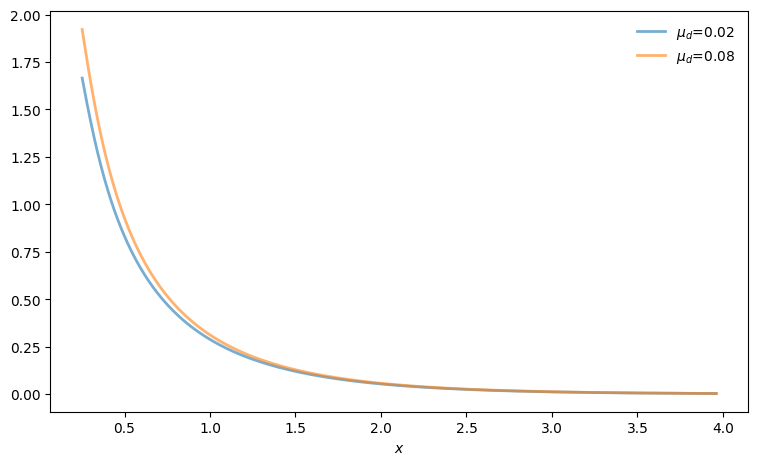

In [5]:
plot_main(savefig=True)

In [6]:
"""

Inventory management model with state-dependent discounting. The discount
factor takes the form β_t = Z_t, where (Z_t) is a discretization of a
Gaussian AR(1) process

    X_t = ρ X_{t-1} + b + ν W_t.

"""

from quantecon import compute_fixed_point
from quantecon.markov import tauchen, MarkovChain

import numpy as np
from time import time
from numba import njit, prange
from collections import namedtuple

# NamedTuple Model
Model = namedtuple("Model", ("K", "c", "κ", "p", "r", 
                             "R", "y_vals", "z_vals", "Q"))


@njit
def ϕ(p, d):
    return (1 - p)**d * p

@njit
def f(y, a, d):
    return np.maximum(y - d, 0) + a  # Inventory update

def create_sdd_inventory_model(
            ρ=0.98, ν=0.002, n_z=20, b=0.97,  # Z state parameters
            K=40, c=0.2, κ=0.8, p=0.6,        # firm and demand parameters
            d_max=100):                        # truncation of demand shock
    d_vals = np.arange(d_max+1)
    ϕ_vals = ϕ(p, d_vals)
    y_vals = np.arange(K+1)
    n_y = len(y_vals)
    mc = tauchen(n_z, ρ, ν)
    z_vals, Q = mc.state_values + b, mc.P
    ρL = np.max(np.abs(np.linalg.eigvals(z_vals * Q)))
    assert ρL < 1, "Error: ρ(L) >= 1."    # check r(L) < 1

    R = np.zeros((n_y, n_y, n_y))
    for i_y, y in enumerate(y_vals):
        for i_y_1, y_1 in enumerate(y_vals):
            for i_a, a in enumerate(range(K - y + 1)):
                hits = [f(y, a, d) == y_1 for d in d_vals]
                R[i_y, i_a, i_y_1] = np.dot(hits, ϕ_vals)


    r = np.empty((n_y, n_y))
    for i_y, y in enumerate(y_vals):
        for i_a, a in enumerate(range(K - y + 1)):
            cost = c * a + κ * (a > 0)
            r[i_y, i_a] = np.dot(np.minimum(y, d_vals),  ϕ_vals) - cost


    return Model(K=K, c=c, κ=κ, p=p, r=r, R=R, 
                 y_vals=y_vals, z_vals=z_vals, Q=Q)

@njit
def B(i_y, i_z, i_a, v, model):
    """
    The function B(x, z, a, v) = r(x, a) + β(z) Σ_x′ v(x′) P(x, a, x′).
    """
    K, c, κ, p, r, R, y_vals, z_vals, Q = model
    β = z_vals[i_z]
    cv = 0.0

    for i_z_1 in prange(len(z_vals)):
        for i_y_1 in prange(len(y_vals)):
            cv += v[i_y_1, i_z_1] * R[i_y, i_a, i_y_1] * Q[i_z, i_z_1]
    return r[i_y, i_a] + β * cv

@njit(parallel=True)
def T(v, model):
    """The Bellman operator."""
    K, c, κ, p, r, R, y_vals, z_vals, Q = model
    new_v = np.empty_like(v)
    for i_z in prange(len(z_vals)):
        for (i_y, y) in enumerate(y_vals):
            Γy = np.arange(K - y + 1)
            new_v[i_y, i_z] = np.max(np.array([B(i_y, i_z, i_a, v, model) 
                               for i_a in Γy]))
    return new_v

@njit
def T_σ(v, σ, model):
    """The policy operator."""
    K, c, κ, p, r, R, y_vals, z_vals, Q = model
    new_v = np.empty_like(v)
    for (i_z, z) in enumerate(z_vals):
        for (i_y, y) in enumerate(y_vals):
            new_v[i_y, i_z] = B(i_y, i_z, σ[i_y, i_z], v, model)
    return new_v

@njit(parallel=True)
def get_greedy(v, model):
    """Get a v-greedy policy.  Returns a zero-based array."""
    K, c, κ, p, r, R, y_vals, z_vals, Q = model
    n_z = len(z_vals)
    σ_star = np.zeros((K+1, n_z), dtype=np.int32)
    for (i_z, z) in enumerate(z_vals):
        for (i_y, y) in enumerate(y_vals):
            Γy = np.arange(K - y + 1)
            i_a = np.argmax(np.array([B(i_y, i_z, i_a, v, model) 
                               for i_a in Γy]))
            σ_star[i_y, i_z] = Γy[i_a]
    return σ_star

@njit
def get_value(v_init, σ, m, model):
    """Approximate lifetime value of policy σ."""
    v = v_init
    for _ in range(m):
        v = T_σ(v, σ, model)
    return v

def solve_inventory_model(v_init, model):
    """Use successive_approx to get v_star and then compute greedy."""
    v_star = compute_fixed_point(lambda v: T(v, model), v_init,
                                 error_tol=1e-5, max_iter=1000, print_skip=25)
    σ_star = get_greedy(v_star, model)
    return v_star, σ_star

def optimistic_policy_iteration(v_init, 
                                model,
                                tolerance=1e-6, 
                                max_iter=1_000,
                                print_step=10,
                                m=60):
    v = v_init
    error = tolerance + 1
    k = 1
    while (error > tolerance) and (k < max_iter):
        last_v = v
        σ = get_greedy(v, model)
        v = get_value(v, σ, m, model)
        error = np.max(np.abs(v - last_v))
        if k % print_step == 0:
            print(f"Completed iteration {k} with error {error}.")
        k += 1
    return v, get_greedy(v, model)


# == Plots == #

import matplotlib.pyplot as plt

# Create an instance of the model and solve it
model = create_sdd_inventory_model()
K, c, κ, p, r, R, y_vals, z_vals, Q = model
n_z = len(z_vals)
v_init = np.zeros((K+1, n_z), dtype=float)
print("Solving model.")
v_star, σ_star = optimistic_policy_iteration(v_init, model)
z_mc = MarkovChain(Q, z_vals)

def sim_inventories(ts_length, X_init=0):
    """Simulate given the optimal policy."""
    global p, z_mc
    i_z = z_mc.simulate_indices(ts_length, init=1)
    X = np.zeros(ts_length, dtype=np.int32)
    X[0] = X_init
    rand = np.random.default_rng().geometric(p=p, size=ts_length-1) - 1
    for t in range(ts_length-1):
        X[t+1] = f(X[t], σ_star[X[t], i_z[t]], rand[t])
    return X, z_vals[i_z]

def plot_ts(ts_length=400,
            fontsize=10,
            figname="../figures/inventory_sdd_ts.pdf",
            savefig=False):
    
    X, Z = sim_inventories(ts_length)
    fig, axes = plt.subplots(2, 1, figsize=(9, 5.5))

    ax = axes[0]
    ax.plot(X, label="inventory", alpha=0.7)
    ax.set_xlabel(r"$t$", fontsize=fontsize)
    ax.legend(fontsize=fontsize, frameon=False)
    ax.set_ylim(0, np.max(X)+3)

    # calculate interest rate from discount factors
    r = (1 / Z) - 1

    ax = axes[1]
    ax.plot(r, label=r"$r_t$", alpha=0.7)
    ax.set_xlabel(r"$t$", fontsize=fontsize)
    ax.legend(fontsize=fontsize, frameon=False)

    plt.tight_layout()
    if savefig:
        fig.savefig(figname)

def plot_timing(m_vals=np.arange(1, 400, 10),
                fontsize=16,
                savefig=False):
    print("Running value function iteration.")
    t_start = time()
    solve_inventory_model(v_init, model)
    vfi_time = time() - t_start
    print(f"VFI completed in {vfi_time} seconds.")
    opi_times = []
    for m in m_vals:
        print(f"Running optimistic policy iteration with m = {m}.")
        t_start = time()
        optimistic_policy_iteration(v_init, model, m=m)
        opi_time = time() - t_start
        print(f"OPI with m = {m} completed in {opi_time} seconds.")
        opi_times.append(opi_time)
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(m_vals, np.full(len(m_vals), vfi_time),
            lw=2, label="value function iteration")
    ax.plot(m_vals, opi_times, lw=2, label="optimistic policy iteration")
    ax.legend(fontsize=fontsize, frameon=False)
    ax.set_xlabel(r"$m$", fontsize=fontsize)
    ax.set_ylabel("time", fontsize=fontsize)
    if savefig:
        fig.savefig("../figures/inventory_sdd_timing.pdf")
    return (opi_time, vfi_time, opi_times)

Solving model.


Completed iteration 10 with error 0.0013695502548998206.


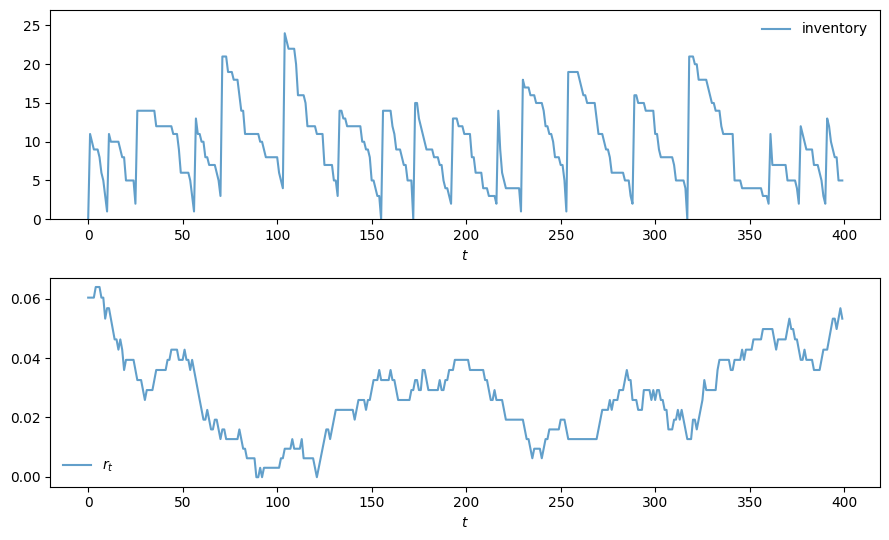

In [7]:
plot_ts(savefig=True)